<a href="https://colab.research.google.com/github/jacksonrn/ufpr-mestrado/blob/main/Exercicio_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Análise Estatística das Features Numéricas:
                    count          mean          std          min  \
Area               3810.0  12667.727559  1732.367706  7551.000000   
Perimeter          3810.0    454.239180    35.597081   359.100006   
Major_Axis_Length  3810.0    188.776222    17.448679   145.264465   
Minor_Axis_Length  3810.0     86.313750     5.729817    59.532406   
Eccentricity       3810.0      0.886871     0.020818     0.777233   
Convex_Area        3810.0  12952.496850  1776.972042  7723.000000   
Extent             3810.0      0.661934     0.077239     0.497413   

                            25%           50%           75%           max  
Area               11370.500000  12421.500000  13950.000000  18913.000000  
Perimeter            426.144752    448.852493    483.683746    548.445984  
Major_Axis_Length    174.353855    185.810059    203.550438    239.010498  
Minor_Axis_Length     82.731695     86.434647     90.143677    107.542450  
Eccentricity           

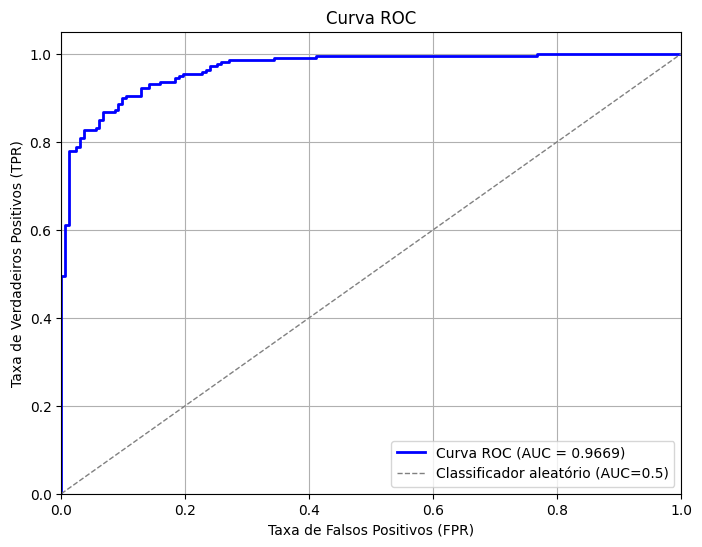

In [ ]:
# Instale as bibliotecas se necessário:
!pip install skorch ucimlrepo

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.helper import predefined_split

from ucimlrepo import fetch_ucirepo
rice = fetch_ucirepo(id=545)

X = rice.data.features
y = rice.data.targets

df = pd.concat([X, y], axis=1)
df = df[df['Class'].isin(['Cammeo', 'Osmancik'])]

numeric_features = df.select_dtypes(include=[np.number])

print("Análise Estatística das Features Numéricas:")
desc = numeric_features.describe().T
print(desc)

print("\nValores ausentes por feature:")
print(numeric_features.isnull().sum())

X = df.drop('Class', axis=1)
y = df['Class']

# Normalização
X = (X - X.min()) / (X.max() - X.min())

# Codificando target
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tensores
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Divisão estratificada
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, temp_idx in sss.split(X_tensor, y_tensor):
    X_train, X_temp = X_tensor[train_idx], X_tensor[temp_idx]
    y_train, y_temp = y_tensor[train_idx], y_tensor[temp_idx]

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("\nDistribuição das classes:")
print("Treino:", np.unique(y_train.numpy(), return_counts=True))
print("Validação:", np.unique(y_valid.numpy(), return_counts=True))
print("Teste:", np.unique(y_test.numpy(), return_counts=True))

# MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, output_dim=2):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Utilização do skorch
net = NeuralNetClassifier(
    SimpleMLP,
    module__input_dim=X.shape[1],
    module__hidden_dim=64,
    module__output_dim=2,
    max_epochs=50,
    lr=0.01,
    optimizer=SGD,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    train_split=predefined_split(torch.utils.data.TensorDataset(X_valid, y_valid)),
    callbacks=[
        EarlyStopping(patience=5),
        EpochScoring(scoring='accuracy', lower_is_better=False, on_train=False)
    ],
    verbose=1
)

#Treino
net.fit(X_train, y_train)

#Avaliação
y_pred = net.predict(X_test)
y_score = net.predict_proba(X_test)[:, 1]

print("\nMétricas no conjunto de teste:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# -------------------- MATRIZ DE CONFUSÃO EM TEXTO --------------------
cm = confusion_matrix(y_test, y_pred)
classes = encoder.classes_

print("\nMatriz de Confusão:")
print(pd.DataFrame(cm, index=classes, columns=classes))

# CURVA ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print("\nCurva ROC (pontos selecionados):")


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Classificador aleatório (AUC=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [ ]:
import torch
import torch.nn as nn
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

features_selected = ['Area', 'Perimeter', 'Major_Axis_Length',
                     'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']

# Filtrando dados para as classes
df_filtered = df[df['Class'].isin(['Cammeo', 'Osmancik'])].copy()

# X e y
X = df_filtered[features_selected]

# Normalização Min-Max
X = (X - X.min()) / (X.max() - X.min())

encoder = LabelEncoder()
y = encoder.fit_transform(df_filtered['Class'])

# Convertendo para tensores torch
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)


class MLPArch(nn.Module):
    def __init__(self, input_size=7, n_layers=4, activation=nn.ReLU, output_size=2):
        super().__init__()
        layers = []

        # input_size -> 16 neurônios
        layers.append(nn.Linear(input_size, 16))
        layers.append(activation())

        # Camadas ocultas adicionais
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(16, 16))
            layers.append(activation())

        self.net = nn.Sequential(*layers)
        self.output = nn.Linear(16, output_size)

    def forward(self, x):
        x = self.net(x)
        x = self.output(x)
        return x

# Parâmetros para busca no GridSearch
param_gridArch1 = {
    'module__n_layers': [2, 5, 10, 20],
    'module__activation': [nn.ReLU, nn.Softsign, nn.Sigmoid],
    'module__input_size': [X.shape[1]],  # 7 features
    'module__output_size': [2],          # 2 classes
}

# Configuração do classificador com Skorch
modelArch = NeuralNetClassifier(
    MLPArch,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=100,
    train_split=None,
    verbose=1,
)

# GridSearch com cross-validation
grid = GridSearchCV(
    estimator=modelArch,
    param_grid=param_gridArch1,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
)

# Treinamento da busca (exemplo usando X_tensor e y_tensor — ajuste para seu conjunto treino)
grid_arch1 = grid.fit(X_tensor, y_tensor)

print("Melhores parâmetros:", grid_arch1.best_params_)
print("Melhor acurácia (validação cruzada):", grid_arch1.best_score_)


  epoch    train_loss     dur
-------  ------------  ------
      1        0.7169  0.1912
      2        0.6907  0.3272
      3        0.6886  0.1911
      4        0.6858  0.2182
      5        0.6788  0.1855
      6        0.6592  0.1324
      7        0.6048  0.2051
      8        0.5076  0.1185
      9        0.4090  0.1206
     10        0.3548  0.1373
     11        0.3213  0.1342
     12        0.3051  0.1189
     13        0.2967  0.1227
     14        0.2903  0.2227
     15        0.2849  0.1251
     16        0.2807  0.1232
     17        0.2774  0.1388
     18        0.2746  0.1235
     19        0.2722  0.1427
     20        0.2701  0.1312
     21        0.2683  0.2199
     22        0.2666  0.1427
     23        0.2652  0.1214
     24        0.2639  0.1279
     25        0.2627  0.1203
     26        0.2616  0.1438
     27        0.2607  0.2089
     28        0.2597  0.1160
     29        0.2589  0.1187
     30        0.2581  0.2159
     31        0.2575  0.1252
     32   

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

y_pred = grid_arch1.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)


              precision    recall  f1-score   support

      Cammeo       0.90      0.93      0.91       163
    Osmancik       0.94      0.92      0.93       218

    accuracy                           0.92       381
   macro avg       0.92      0.92      0.92       381
weighted avg       0.92      0.92      0.92       381

Matriz de Confusão:
[[151  12]
 [ 17 201]]


In [ ]:
y_proba = grid_arch1.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

print(f"AUC: {auc:.4f}")
print("FPR\tTPR\tThreshold")
for f, t, th in zip(fpr, tpr, thresholds):
    print(f"{f:.3f}\t{t:.3f}\t{th:.3f}")


AUC: 0.9789
FPR	TPR	Threshold
0.000	0.000	inf
0.000	0.005	0.976
0.000	0.716	0.945
0.006	0.716	0.944
0.006	0.784	0.931
0.018	0.784	0.928
0.018	0.821	0.917
0.025	0.821	0.916
0.025	0.858	0.898
0.037	0.858	0.880
0.037	0.885	0.844
0.049	0.885	0.807
0.049	0.894	0.800
0.055	0.894	0.779
0.055	0.917	0.726
0.067	0.917	0.679
0.067	0.922	0.638
0.086	0.922	0.482
0.086	0.927	0.479
0.092	0.927	0.465
0.092	0.931	0.446
0.098	0.931	0.380
0.098	0.936	0.361
0.110	0.936	0.332
0.110	0.940	0.309
0.117	0.940	0.302
0.117	0.945	0.278
0.141	0.945	0.234
0.141	0.950	0.201
0.147	0.950	0.193
0.147	0.959	0.173
0.178	0.959	0.158
0.178	0.963	0.158
0.202	0.963	0.137
0.202	0.968	0.137
0.209	0.968	0.133
0.209	0.972	0.127
0.233	0.972	0.103
0.233	0.977	0.102
0.239	0.977	0.101
0.239	0.986	0.098
0.282	0.986	0.087
0.282	0.991	0.086
0.294	0.991	0.084
0.294	0.995	0.084
0.675	0.995	0.054
0.675	1.000	0.054
1.000	1.000	0.041


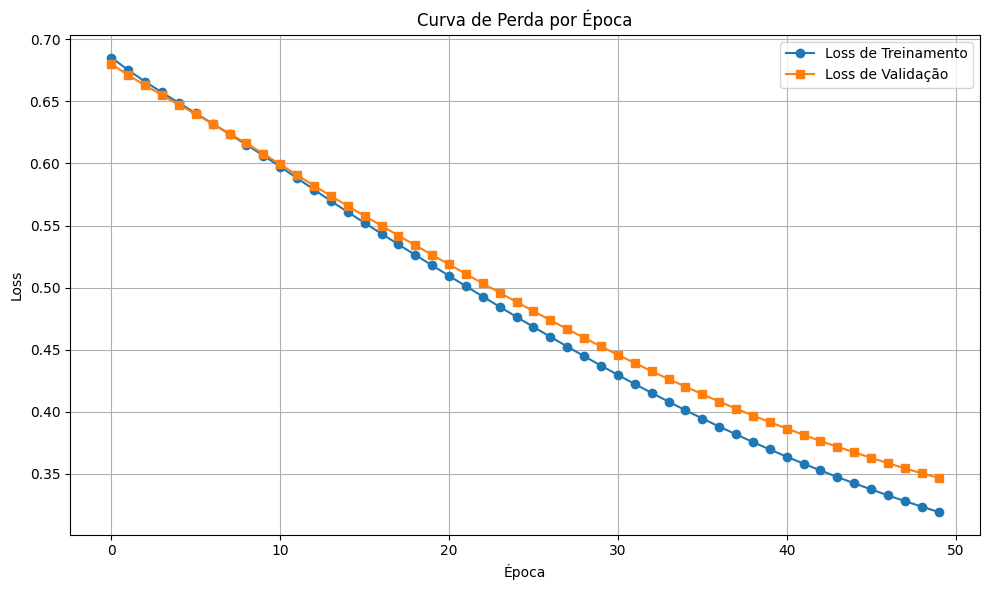

In [ ]:
import matplotlib.pyplot as plt

# Acessa os valores de perda por época a partir do histórico do skorch
train_loss = [epoch['train_loss'] for epoch in net.history]
valid_loss = [epoch.get('valid_loss') for epoch in net.history]

# Plot da curva de perda
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Loss de Treinamento', marker='o')
if all(v is not None for v in valid_loss):
    plt.plot(valid_loss, label='Loss de Validação', marker='s')

plt.title('Curva de Perda por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Curva de Perda
print("Época\tLoss Treinamento\tLoss Validação")
for i, epoch in enumerate(net.history):
    train_loss = epoch['train_loss']
    valid_loss = epoch.get('valid_loss', None)
    print(f"{i+1}\t{train_loss:.4f}\t\t\t{valid_loss:.4f}" if valid_loss is not None else f"{i+1}\t{train_loss:.4f}\t\t\tN/A")


Época	Loss Treinamento	Loss Validação
1	0.6852			0.6799
2	0.6751			0.6710
3	0.6658			0.6629
4	0.6571			0.6550
5	0.6487			0.6473
6	0.6403			0.6396
7	0.6319			0.6319
8	0.6236			0.6240
9	0.6150			0.6160
10	0.6063			0.6077
11	0.5973			0.5992
12	0.5882			0.5906
13	0.5789			0.5821
14	0.5698			0.5738
15	0.5609			0.5657
16	0.5521			0.5577
17	0.5434			0.5498
18	0.5348			0.5419
19	0.5263			0.5341
20	0.5179			0.5263
21	0.5095			0.5186
22	0.5011			0.5110
23	0.4928			0.5034
24	0.4845			0.4959
25	0.4764			0.4885
26	0.4684			0.4810
27	0.4604			0.4738
28	0.4525			0.4666
29	0.4448			0.4596
30	0.4372			0.4527
31	0.4297			0.4459
32	0.4224			0.4393
33	0.4153			0.4327
34	0.4082			0.4264
35	0.4013			0.4203
36	0.3946			0.4142
37	0.3881			0.4083
38	0.3819			0.4026
39	0.3757			0.3970
40	0.3697			0.3917
41	0.3639			0.3865
42	0.3583			0.3815
43	0.3528			0.3765
44	0.3475			0.3719
45	0.3424			0.3674
46	0.3376			0.3629
47	0.3327			0.3587
48	0.3281			0.3545
49	0.3237			0.3505
50	0.3194			0.3468


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_test, y_pred)
classes = encoder.classes_

# Mostrar matriz em formato tabular
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

print("Matriz de Confusão:")
print(cm_df.to_string())


Matriz de Confusão:
          Cammeo  Osmancik
Cammeo       151        12
Osmancik      17       201


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Melhores parâmetros SVM: {'C': 10, 'kernel': 'rbf'}

Métricas no conjunto de teste SVM:
Acurácia: 0.9055
Precisão: 0.9027
Revocação: 0.9358
F1 Score: 0.9189

Matriz de Confusão SVM:
          Cammeo  Osmancik
Cammeo       141        22
Osmancik      14       204

AUC: 0.9597
FPR	TPR	Threshold
0.000	0.000	inf
0.000	0.005	1.000
0.000	0.174	0.978
0.006	0.174	0.978
0.006	0.234	0.973
0.012	0.234	0.973
0.012	0.372	0.962
0.018	0.372	0.961
0.018	0.417	0.957
0.025	0.417	0.957
0.025	0.427	0.957
0.031	0.427	0.957
0.031	0.803	0.931
0.037	0.803	0.930
0.037	0.904	0.913
0.043	0.904	0.906
0.043	0.908	0.894
0.049	0.908	0.892
0.049	0.913	0.888
0.055	0.913	0.880
0.055	0.917	0.867
0.092	0.917	0.731
0.092	0.922	0.720
0.098	0.922	0.644
0.098	0.927	0.629
0.110	0.927	0.611
0.110	0.931	0.607
0.129	0.931	0.553
0.129	0.936	0.549
0.135	0.936	0.547
0.135	0.940	0.518
0.147	0.940	0.500
0.147	0.945	0.466
0.153	0.945	0.459
0.153	0.954	0.450
0.160	0.954	0.442

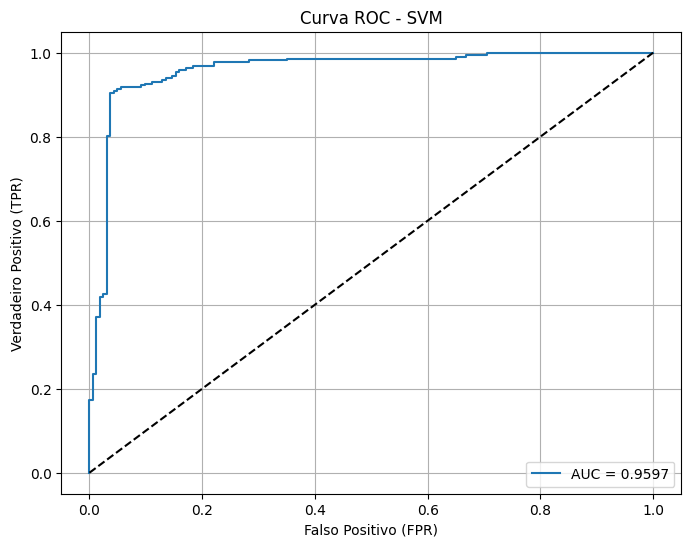

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt

# Parâmetros
param_grid = {
    'C': [10, 50, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    # 'degree': [2, 3, 4],  # Só para 'poly' se quiser usar
    # 'gamma': ['scale', 'auto', 0.1, 1, 10],  # Opcional
    # 'class_weight': [None, 'balanced'],
}

# Instanciar o modelo SVM
svm = SVC(probability=True)  # probability=True para gerar scores ROC

# Configurar GridSearch
grid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=1)

# Treinar
grid_search.fit(X_train.numpy(), y_train.numpy())

print("Melhores parâmetros SVM:", grid_search.best_params_)

# Avaliação no conjunto teste
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test.numpy())
y_proba = best_svm.predict_proba(X_test.numpy())[:, 1]

print("\nMétricas no conjunto de teste SVM:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão SVM:")
print(pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_))

# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"\nAUC: {roc_auc:.4f}")
print("FPR\tTPR\tThreshold")
for f, t, th in zip(fpr, tpr, thresholds):
    print(f"{f:.3f}\t{t:.3f}\t{th:.3f}")

# Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('Curva ROC - SVM')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

print("FPR\tTPR\tThreshold")
for f, t, th in zip(fpr, tpr, thresholds):
    print(f"{f:.3f}\t{t:.3f}\t{th:.3f}")


FPR	TPR	Threshold
0.000	0.000	inf
0.000	0.005	1.000
0.000	0.174	0.978
0.006	0.174	0.978
0.006	0.234	0.973
0.012	0.234	0.973
0.012	0.372	0.962
0.018	0.372	0.961
0.018	0.417	0.957
0.025	0.417	0.957
0.025	0.427	0.957
0.031	0.427	0.957
0.031	0.803	0.931
0.037	0.803	0.930
0.037	0.904	0.913
0.043	0.904	0.906
0.043	0.908	0.894
0.049	0.908	0.892
0.049	0.913	0.888
0.055	0.913	0.880
0.055	0.917	0.867
0.092	0.917	0.731
0.092	0.922	0.720
0.098	0.922	0.644
0.098	0.927	0.629
0.110	0.927	0.611
0.110	0.931	0.607
0.129	0.931	0.553
0.129	0.936	0.549
0.135	0.936	0.547
0.135	0.940	0.518
0.147	0.940	0.500
0.147	0.945	0.466
0.153	0.945	0.459
0.153	0.954	0.450
0.160	0.954	0.442
0.160	0.959	0.404
0.172	0.959	0.331
0.172	0.963	0.313
0.184	0.963	0.298
0.184	0.968	0.292
0.221	0.968	0.190
0.221	0.977	0.120
0.282	0.977	0.087
0.282	0.982	0.087
0.350	0.982	0.069
0.350	0.986	0.069
0.650	0.986	0.043
0.650	0.991	0.043
0.669	0.991	0.042
0.669	0.995	0.042
0.706	0.995	0.037
0.706	1.000	0.036
1.000	1.000	0.002


In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

pipe = Pipeline([
    ('pca', PCA()),
    ('svm', SVC(probability=True))
])

# Grid de parâmetros para buscar melhores valores
param_grid = {
    'pca__n_components': [5, 10, 15, 20],
    'svm__C': [10, 50, 100],
    'svm__kernel': ['linear', 'rbf'],
}

# GridSearch com 3 folds
grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=2)

# Treino com os dados do treino
grid.fit(X_train, y_train)

# Melhore parâmetros encontrados
print("Melhores parâmetros PCA com SVM:", grid.best_params_)

# Avalia no teste
y_pred = grid.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred, average='weighted'))
print("Revocação:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# AUC binária
if len(set(y_test)) == 2:
    y_scores = grid.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    print("AUC:", round(auc, 4))


# Ver se o problema é binário
if len(set(y_test)) == 2:
    y_scores = grid.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    print("AUC:", round(auc, 4))



Fitting 3 folds for each of 24 candidates, totalling 72 fits
Melhores parâmetros PCA com SVM: {'pca__n_components': 5, 'svm__C': 50, 'svm__kernel': 'linear'}
Acurácia: 0.916010498687664
Precisão: 0.9162430702442526
Revocação: 0.916010498687664
F1 Score: 0.9157106891470286
Matriz de Confusão:
 [[143  20]
 [ 12 206]]


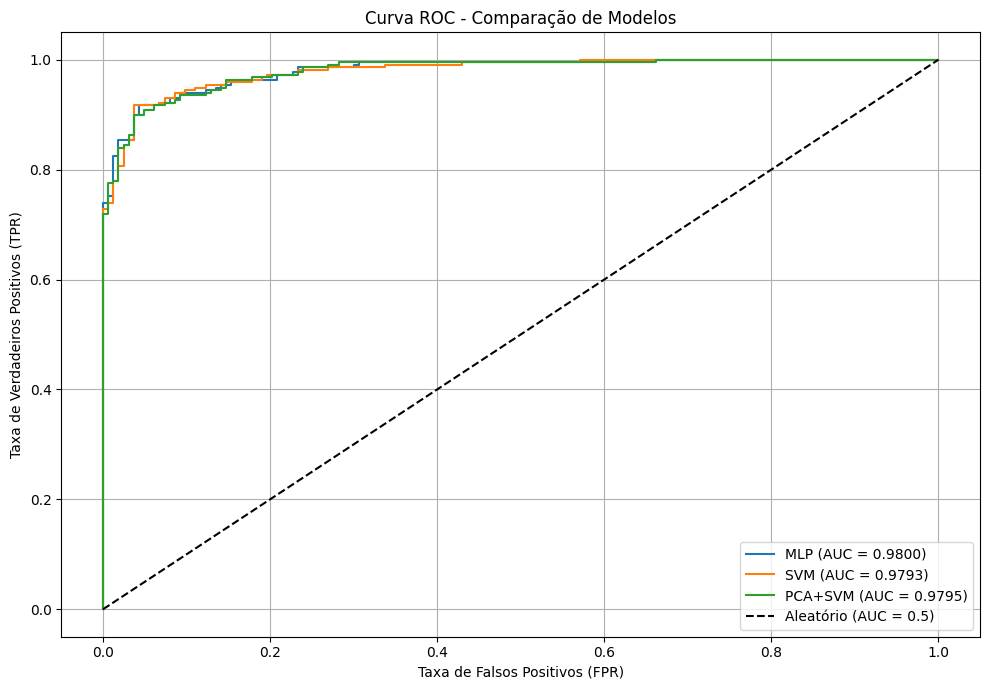


Curva ROC - MLP
FPR	TPR	Threshold
0.000	0.000	inf
0.000	0.005	1.000
0.000	0.739	0.952
0.006	0.739	0.950
0.006	0.752	0.944
0.012	0.752	0.943
0.012	0.826	0.911
0.018	0.826	0.910
0.018	0.853	0.894
0.037	0.853	0.880
0.037	0.899	0.832
0.043	0.899	0.819
0.043	0.917	0.773
0.067	0.917	0.715
0.067	0.922	0.715
0.080	0.922	0.636
0.080	0.931	0.614
0.092	0.931	0.597
0.092	0.940	0.580
0.123	0.940	0.516
0.123	0.945	0.475
0.135	0.945	0.467
0.135	0.950	0.467
0.141	0.950	0.465
0.141	0.954	0.463
0.153	0.954	0.403
0.153	0.959	0.399
0.160	0.959	0.386
0.160	0.963	0.371
0.209	0.963	0.314
0.209	0.972	0.290
0.227	0.972	0.216
0.227	0.977	0.203
0.233	0.977	0.200
0.233	0.986	0.190
0.301	0.986	0.111
0.301	0.991	0.108
0.307	0.991	0.106
0.307	0.995	0.097
0.656	0.995	0.010
0.656	1.000	0.009
1.000	1.000	0.000

Curva ROC - SVM
FPR	TPR	Threshold
0.000	0.000	inf
0.000	0.005	1.000
0.000	0.729	0.952
0.006	0.729	0.952
0.006	0.739	0.948
0.012	0.739	0.945
0.012	0.780	0.935
0.018	0.780	0.935
0.018	0.807	0.925
0.025	0.807	0.92

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_curve, roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler

#Standardização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_proba_mlp = mlp.predict_proba(X_test_scaled)[:, 1]
auc_mlp = roc_auc_score(y_test, y_proba_mlp)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_proba_mlp)


# Modelo 2: SVM com GridSearchCV

svm = SVC(probability=True)
param_svm = {'C': [10, 50, 100], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(svm, param_svm, cv=3, n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)
y_proba_svm = grid_svm.predict_proba(X_test_scaled)[:, 1]
auc_svm = roc_auc_score(y_test, y_proba_svm)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_proba_svm)

# SVM com PCA

pipe = Pipeline([
    ('pca', PCA()),
    ('svm', SVC(probability=True))
])
param_pca_svm = {
    'pca__n_components': [5, 10, 15, 20],
    'svm__C': [10, 50, 100],
    'svm__kernel': ['linear', 'rbf']
}
grid_pca_svm = GridSearchCV(pipe, param_pca_svm, cv=3, n_jobs=-1)
grid_pca_svm.fit(X_train_scaled, y_train)
y_proba_pca = grid_pca_svm.predict_proba(X_test_scaled)[:, 1]
auc_pca = roc_auc_score(y_test, y_proba_pca)
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_test, y_proba_pca)

# Curva ROC

plt.figure(figsize=(10, 7))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.4f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.4f})")
plt.plot(fpr_pca, tpr_pca, label=f"PCA+SVM (AUC = {auc_pca:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Aleatório (AUC = 0.5)")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Comparação de Modelos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def print_roc_info(fpr, tpr, thresholds, label):
    print(f"\nCurva ROC - {label}")
    print("FPR\tTPR\tThreshold")
    for f, t, th in zip(fpr, tpr, thresholds):
        print(f"{f:.3f}\t{t:.3f}\t{th:.3f}")

print_roc_info(fpr_mlp, tpr_mlp, thresholds_mlp, "MLP")
print_roc_info(fpr_svm, tpr_svm, thresholds_svm, "SVM")
print_roc_info(fpr_pca, tpr_pca, thresholds_pca, "PCA+SVM")


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#MLP

mlp = MLPClassifier(random_state=42, max_iter=500)
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'alpha': [0.0001, 0.001],
    'activation': ['relu', 'tanh']
}
mlp_grid = GridSearchCV(mlp, mlp_param_grid, cv=3, n_jobs=-1, verbose=1)
mlp_grid.fit(X_train, y_train)
y_pred_mlp = mlp_grid.predict(X_test)
print("MLP - Melhor Params:", mlp_grid.best_params_)
print("MLP - Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_mlp))
print("MLP - Relatório de Classificação:\n", classification_report(y_test, y_pred_mlp))

#SVM linear/rbf

svm = SVC(probability=True, random_state=42)
svm_param_grid = {
    'C': [10, 50],
    'kernel': ['linear', 'rbf']
}
svm_grid = GridSearchCV(svm, svm_param_grid, cv=3, n_jobs=-1, verbose=1)
svm_grid.fit(X_train, y_train)
y_pred_svm = svm_grid.predict(X_test)
print("SVM - Melhor Params:", svm_grid.best_params_)
print("SVM - Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_svm))
print("SVM - Relatório de Classificação:\n", classification_report(y_test, y_pred_svm))

# SVM com PCA

pipe = Pipeline([
    ('pca', PCA()),
    ('svm', SVC(probability=True, random_state=42))
])
param_grid_pca_svm = {
    'pca__n_components': [5, 10, 15],
    'svm__C': [10, 50],
    'svm__kernel': ['linear', 'rbf']
}
pca_svm_grid = GridSearchCV(pipe, param_grid_pca_svm, cv=3, n_jobs=-1, verbose=1)
pca_svm_grid.fit(X_train, y_train)
y_pred_pca_svm = pca_svm_grid.predict(X_test)
print("PCA+SVM - Melhor Params:", pca_svm_grid.best_params_)
print("PCA+SVM - Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_pca_svm))
print("PCA+SVM - Relatório de Classificação:\n", classification_report(y_test, y_pred_pca_svm))

acc_mlp = accuracy_score(y_test, y_pred_mlp)
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_pca_svm = accuracy_score(y_test, y_pred_pca_svm)

print(f"\nAcurácia MLP: {acc_mlp:.4f}")
print(f"Acurácia SVM: {acc_svm:.4f}")
print(f"Acurácia PCA+SVM: {acc_pca_svm:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
MLP - Melhor Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
MLP - Matriz de Confusão:
 [[141  22]
 [ 12 206]]
MLP - Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       163
           1       0.90      0.94      0.92       218

    accuracy                           0.91       381
   macro avg       0.91      0.90      0.91       381
weighted avg       0.91      0.91      0.91       381

Fitting 3 folds for each of 4 candidates, totalling 12 fits
SVM - Melhor Params: {'C': 10, 'kernel': 'rbf'}
SVM - Matriz de Confusão:
 [[141  22]
 [ 14 204]]
SVM - Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       163
           1       0.90      0.94      0.92       218

    accuracy                           0.91       381
   macro avg       0.91    